# Modelling liquid-line-of-descents with MAGEMin

- One of the primary uses of the MELTS models is simulating the crystallisation of magma under different conditions.
- Useful for identifying whether samples are linked by crystallisation or if other processes are required to explain the geochemical variability of a region.

**Before any calculations can be run** users need to make sure they have followed the instructions for installing juliacall and the necessary MAGEMin packages.

Data used in the calculations below can be downloaded from here: https://github.com/gleesonm1/PetThermoTools/blob/master/docs/Examples/CrystallisationTests/Fernandina_glass.xlsx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import petthermotools as ptt

In this notebook we'll show how PetThermoTools can quickly perform multiple calculations (utilizing parallel processing), and investigate how the liquid-line-of-descent is linked to the conditions of magma storage. **Note: this notebook is near identical to the standard liquid-line-of-descent example but uses the Green et al. (2025) and Weller et al. (2024) thermodynamic models through MAGEMin; Riel et al. (2022).**

First, we need to load in some data. For this example we'll use data from Isla Fernandina in the Galapagos Archipelago, where a series of melt inclusions (Koleszar et al. 2009) and matrix glasses (Peterson et al. 2017) provide us with plenty of glass data to constain the magmatic evolution of the sub-volcanic system. The melt inclusion and matrix glass data is included in a single excel spreadsheet that we can load in using Pandas. We can also split this DataFrame into two. One containing just the melt inclusion data, the second including just the matrix glass data.

In [2]:
df = pd.read_excel('Fernandina_glass.xlsx')
df = df.fillna(0)

# split data based on the Group (Melt Inclusion or Matrix Glass)
MI = df.loc[df['Group'] == 'MI',:].reset_index(drop = True)
MG = df.loc[df['Group'] == 'MG',:].reset_index(drop = True)

MG.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MG,-0.17,-91.77,49.11,2.90,14.04,11.38,0.21,6.53,11.88,2.55,0.43,0.30,0.593,0.011442
1,MG,-0.17,-91.77,49.22,3.10,14.09,11.37,0.20,6.75,11.78,2.75,0.44,0.31,0.683,0.009890
2,MG,-0.21,-91.81,49.01,2.92,13.92,11.74,0.21,6.31,11.90,2.55,0.46,0.33,0.635,0.012210
3,MG,-0.21,-91.80,49.42,3.14,13.92,11.77,0.20,6.47,11.46,2.82,0.46,0.33,0.732,0.010531
4,MG,-0.24,-91.75,48.76,3.57,13.88,11.83,0.23,6.37,11.40,3.09,0.52,0.36,0.834,0.007797


One of the key things that we need to perform any calculations with MELTS is a starting composition. To start, let's use the most primitive (highest MgO) composition from the melt inclusion analyses. There are a few ways to find this composition, the way I like to do so (not necessarily the quickest) is to simply sort the melt inclusion DataFrame by the MgO contents and select the first row:

In [3]:
MI = MI.sort_values('MgO', ascending = False, ignore_index = True)
MI.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MI,0.0,0.0,47.5,2.29,16.4,9.16,0.123,9.38,11.6,2.25,0.329,0.257,0.68,0.0280
1,MI,0.0,0.0,47.5,2.58,15.5,10.04,0.138,8.97,11.4,2.44,0.428,0.262,0.69,0.0630
2,MI,0.0,0.0,49.2,2.33,16.0,8.67,0.147,8.94,12.0,1.78,0.005,0.094,0.78,0.0004
3,MI,0.0,0.0,48.4,2.50,15.7,9.07,0.139,8.88,11.6,2.18,0.398,0.326,0.69,0.0126
4,MI,0.0,0.0,48.1,2.46,15.3,8.96,0.153,8.82,12.1,2.34,0.325,0.387,0.88,0.4986


In [4]:
starting_comp = MI.loc[0]
starting_comp

Group           MI
Latitude       0.0
Longitude      0.0
SiO2          47.5
TiO2          2.29
Al2O3         16.4
FeOt          9.16
MnO          0.123
MgO           9.38
CaO           11.6
Na2O          2.25
K2O          0.329
P2O5         0.257
H2O           0.68
CO2          0.028
Name: 0, dtype: object

We can now perform crystallisation calculations. These calculations are run using the Weller et al. (2024) thermodynamic model, start at the liquidus and end at 1100$^o$C. The calculations are also run at 1 log unit below the FMQ buffer. By specifying Frac_solid = True, we inform PetThermoTools that we want to perform a fractional (rather than equilibrium) crystallisation scenario.

In [5]:
Weller_Xtal = ptt.isobaric_crystallisation(Model = "Weller2024",
                                           bulk = starting_comp.to_dict(),
                                           find_liquidus = True,
                                           P_bar = np.array([500.0,1000.0,2000.0,4000.0]),
                                           T_end_C = 1100.0,
                                           dt_C = 2.0,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           label = 'pressure',
                                           Frac_solid = True,
                                           timeout = 300)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating  Activating  project at `~/.petthermotools_julia_env`project at `~/.petthermotools_julia_env`

  Activating project at `~/.petthermotools_julia_env`
  Activating project at `~/.petthermotools_julia_env`


Using libMAGEMin.dylib from MAGEMin_jllUsing libMAGEMin.dylib from MAGEMin_jllUsing libMAGEMin.dylib from MAGEMin_jllUsing libMAGEMin.dylib from MAGEMin_jll



igad
igad
igad
igad
Completed 100.0 %


We can also run the same calculations using the Green et al. (2025) thermodynamic model (through MAGEMin_C).

In [6]:
Green_Xtal = ptt.isobaric_crystallisation(Model = "Green2025",
                                           bulk = starting_comp.to_dict(),
                                           find_liquidus = True,
                                           P_bar = np.array([500.0,1000.0,2000.0,4000.0]),
                                           T_end_C = 1100.0,
                                           dt_C = 2.0,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           label = 'pressure',
                                           Frac_solid = True,
                                           timeout = 300)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.petthermotools_julia_env`
  Activating project at `~/.petthermotools_julia_env`
  Activating project at `~/.petthermotools_julia_env`


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.petthermotools_julia_env`


Using libMAGEMin.dylib from MAGEMin_jllUsing libMAGEMin.dylib from MAGEMin_jll

Using libMAGEMin.dylib from MAGEMin_jll
Using libMAGEMin.dylib from MAGEMin_jll
ig
ig
ig
ig
Completed 100.0 %


There are several ways to display the results. Option 1 is to use the in-built harker plotting function which directly plots a 3-by-2 group of plots without having to make any changes to the output from the crystallisation models. You'll see below that the code also allows other data to be loaded and plotted alongside the models: 

In [9]:
Green_Xtal['P = 500.0 bars']['Mass']

,cpx1,ol1,fsp1,liq1,cpx1_cumsum,ol1_cumsum,fsp1_cumsum
0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4,0.000000,0.000924,0.000000,0.999076,0.000000,0.000924,0.000000
5,0.000000,0.001416,0.000000,0.998584,0.000000,0.002340,0.000000
6,0.000000,0.001412,0.000000,0.998588,0.000000,0.003752,0.000000
7,0.000000,0.001407,0.000000,0.998593,0.000000,0.005159,0.000000
8,0.000000,0.001402,0.000000,0.998598,0.000000,0.006561,0.000000
9,0.000000,0.001397,0.000000,0.998603,0.000000,0.007958,0.000000


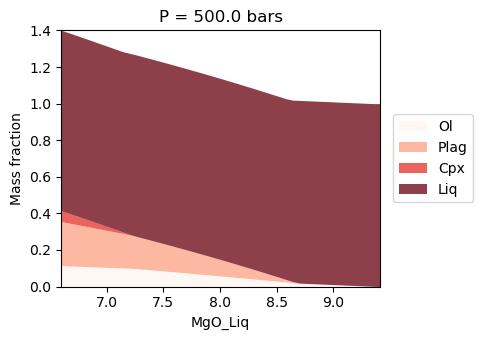

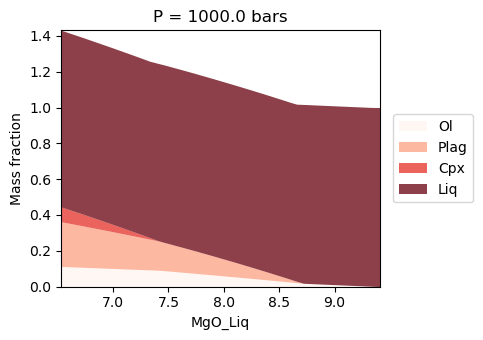

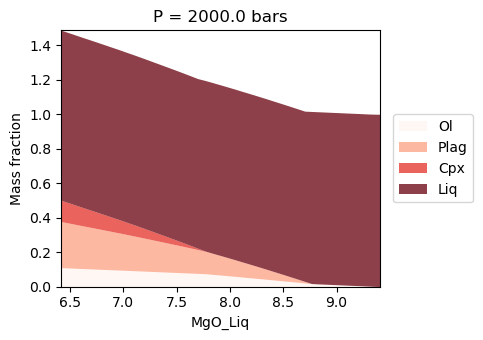

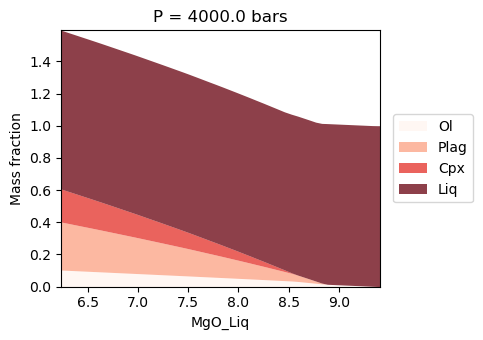

In [7]:
fig, axes = ptt.phase_plot(Results = Green_Xtal, x_axis = 'MgO_Liq', cmap = 'Reds')

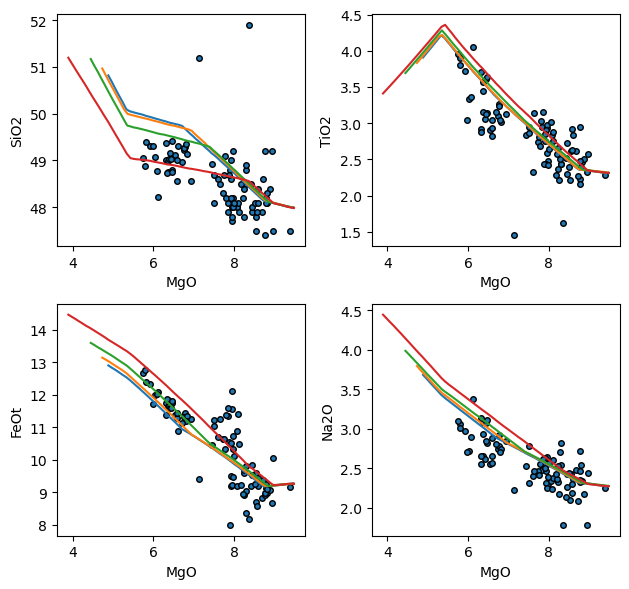

In [10]:
f, a = ptt.harker(Results = Weller_Xtal, data = df, y_axis = ('SiO2', 'TiO2', 'FeOt', 'Na2O'), legend=False)

The plot above shows the results using the Weller et al. (2024) model. To plot the results of the Green et al. (2025) calculations we just need to change the parameter passed to the `Results` kwarg:

In [13]:
ptt.harker(Results = Green_Xtal, data = df)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 960x0 with 0 Axes>

/Users/gleesonm/anaconda3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Users/gleesonm/anaconda3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Users/gleesonm/anaconda3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Users/gleesonm/anaconda3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


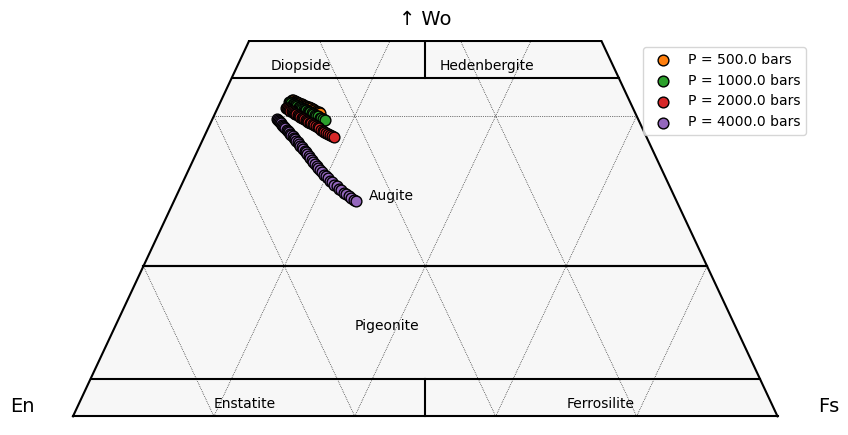

In [12]:
import Thermobar as pt
f, tax = pt.plot_px_classification(figsize = (10,5),major_grid = True, labels = True)
for i in Weller_Xtal.keys():   
    cpx_comps_tern_1 = pt.tern_points_px(px_comps = Weller_Xtal[i]['cpx1'])
    tax.scatter(cpx_comps_tern_1,edgecolor = 'k',marker = 'o',s = 60, label = i)
tax.legend()